# RF superconducting qubit readout 101

This example shows a basic demonstration of reading out an emulated qubit, including measurements of single shot readout fidelity, T1, and Rabi oscillation.

In [1]:
import sys
# sys.path.append('../qick/qick_lib/')
sys.path.append('../soft/')
sys.path.append('../firmware/')

from hist_analysis import *
from qick import *
from qick_training import *

from qick.averager_program import QickSweep
from qick.averager_program import QickRegister
from qick.averager_program import merge_sweeps

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from tqdm.notebook import tqdm
from random import *
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import cauchy

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Initialize Firmware.
soc = QickTrainingSoc('../firmware/qick_training.bit')

# Print information.
soccfg = soc
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.179
	Firmware timestamp: Wed Sep  6 15:36:36 2023

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, blk 1, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, blk 2, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, blk 3, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=307.200 MHz, f_dds=4915.200 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, blk 2, 32-

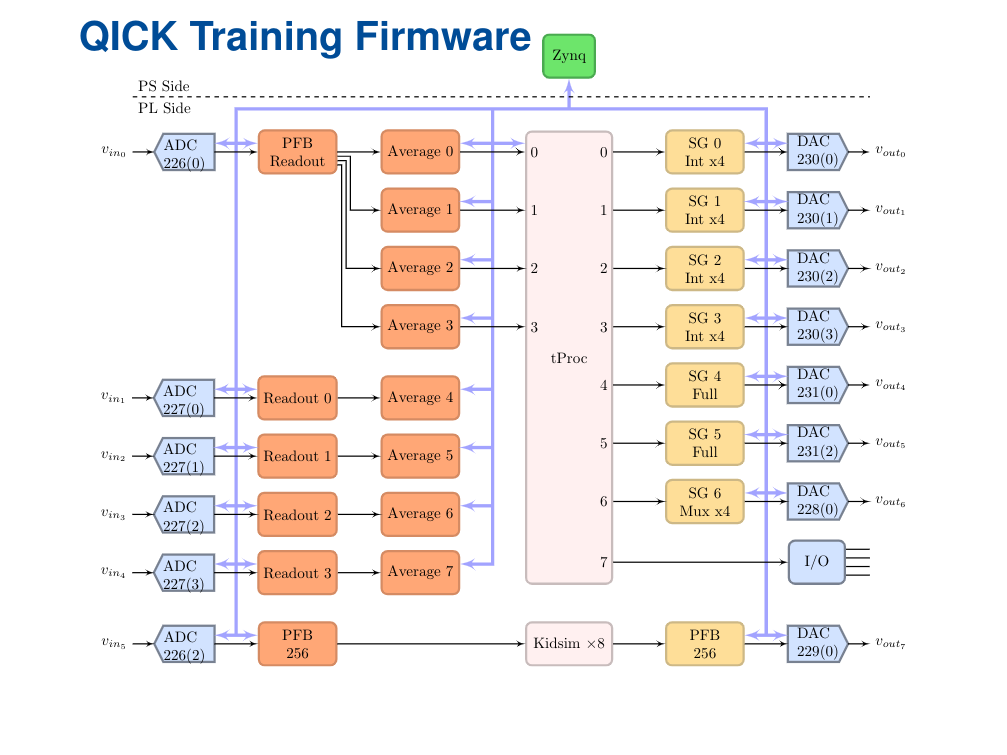

In [3]:
from IPython.display import Image, display
display(Image(filename='images/Qick_training.png', embed=True))

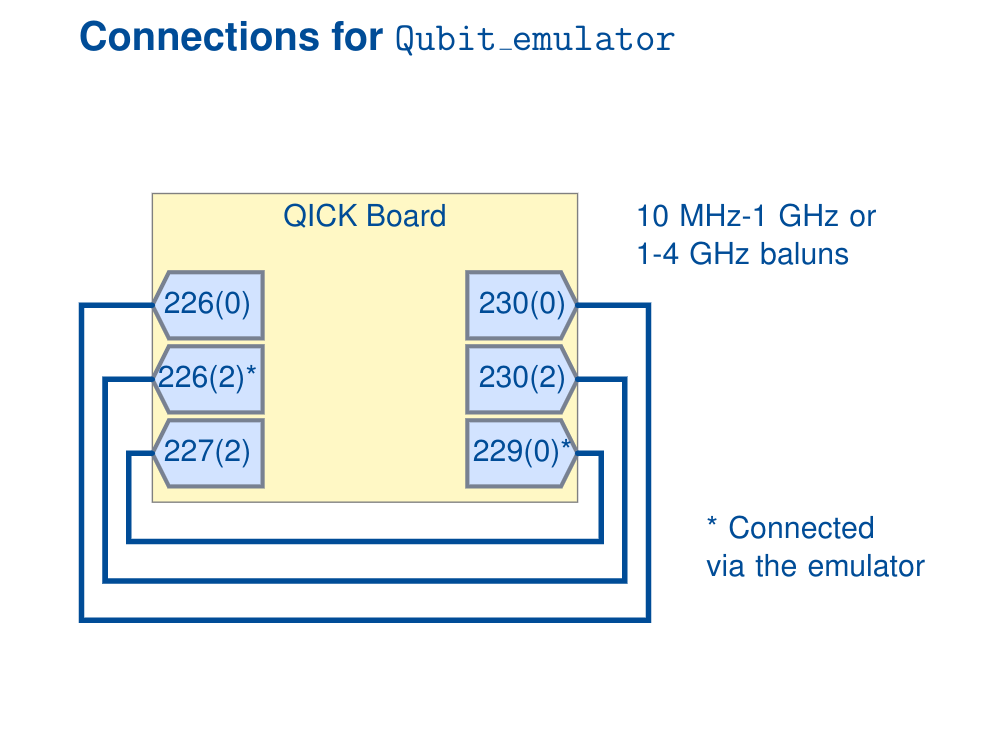

In [4]:
display(Image(filename='images/Connections_Qubit_emulator.png', embed=True))

In [5]:
######################################
### Build Resonator Emulator Chain ###
######################################
simu = SimuChain(soc,soc['simu'][0], name="226_2 <-> 229_0")

# RF superconducting qubit readout 101

# Set up your resonator

This resonator's frequency is 500 MHz. The resonator has a certain internal quality factor, which you will extract by fitting it in a cell below. We have set the resonator up to jump from one frequency to the other in 7 us, in a single step.

In [6]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
#simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()


fr = 500
res_jump_time = 6.2
### Resonator configuration. Note that some of these config parameters depend on each other, 
### so not every configuration is possible.
cfg = {'sel' : 'resonator', 'freq' : fr}
cfg['nstep'] = 1 # 3
cfg['sweep_time'] = res_jump_time # should be a little longer than readout time (5 us)
simu.set_resonator(cfg, verbose=True)

SimuChain: f = 500 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.99
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9045226130653267
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 58
AxisKidsimV3: sweep_freq = 0.9
AxisKidsimV3: sweep_time = 6.2
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 6144, slope = 6144, steps = 1, wait = 58
c0 = 32440, c1 = 26214, g = 29639
sel = 0, punct_id = 29, addr = 0


In [7]:
class VnaProgram(NDAveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=2)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'],gen_ch=self.cfg['gen_ch'],ro_ch=self.cfg['ro_ch'])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['pulse_freq'],
                             sel     = self.cfg['ro_sel'],
                             gen_ch  = self.cfg['gen_ch'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phrst=0, mode="oneshot")
        
        self.synci(200)  # give processor some time to configure pulses
        
        # Trigger resonator.
        if self.cfg['qubit_jump']:
            self.trigger(pins=[4,5,6,7,8,9,10,11],t=self.us2cycles(0))
    
    def body(self):
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.ro_chs,
                     pins            = [0], 
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset']),
                     )

# Resonator spectroscopy

By measuring the complex S_21 of the resonator around its resonant frequency, we can find its resonance and then fit it to find its internal quality factor. Let's measure this S_21 of our resonator.

Sweep Parameters
* fstart = 490.0 MHz
* fstop  = 510.0 MHz
* N      = 1500
* fr     = 0.013342228152112057 MHz


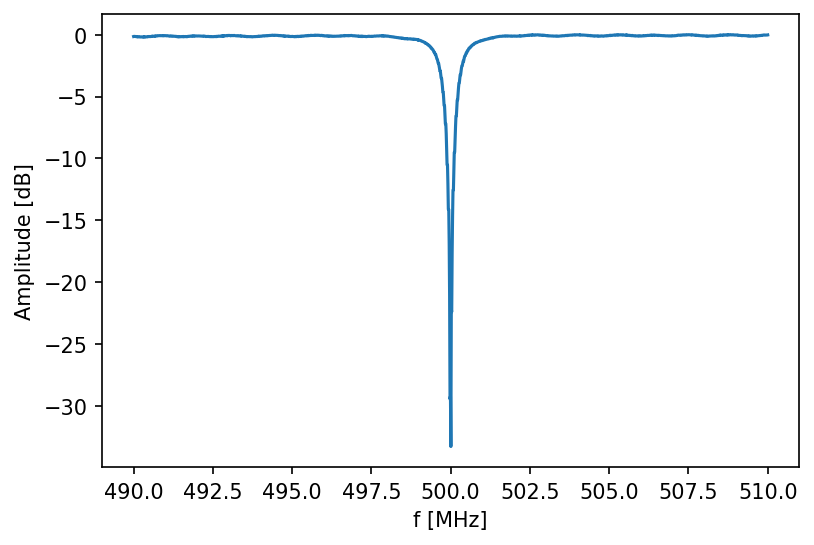

In [11]:
# Frequency sweep.
fc = fr
df = 20
fstart = fc - df/2
fstop = fc + df/2
N = 1500
freqs = np.linspace(start=fstart, stop=fstop, num=N)
print('Sweep Parameters')
print('* fstart = {} MHz'.format(fstart))
print('* fstop  = {} MHz'.format(fstop))
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(freqs[1]-freqs[0]))

config={"gen_ch"      : 2,
        "reps"        : 1,
        "pulse_length": 15,
        "pulse_gain"  : 15000, # [DAC units]
        "pulse_freq"  : fr, # [MHz]
        "qubit_jump"  : True
       }

ro_cfg = {
    "ro_ch"     : 6,
    "ro_length" : 10,
    "ro_sel"    : 'product',
    "ro_offset" : 10,
    "soft_avgs" : 1
}

config.update(**ro_cfg)

xi_v = np.zeros(len(freqs))
xq_v = np.zeros(len(freqs))
for i,f in enumerate(freqs):
    config['pulse_freq'] = f
    prog = VnaProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    xi,xq = res[1].item(),res[2].item()
    
    xi_v[i] = xi
    xq_v[i] = xq
    
x = xi_v + 1j*xq_v
a = np.abs(x)
phi = np.angle(x)
S21 = 20*np.log10(a/np.max(a))

#############
### Plots ###
#############
plt.figure(dpi=150)
plt.plot(freqs,S21)
plt.xlabel('f [MHz]')
plt.ylabel('Amplitude [dB]');

### Let's fit this resonator and extract its quality factor. 

Q = f/kappa, where kappa is the linewidth of the resonator-- its full width at half maximum.

### 1. Find the full width, half maximum (kappa) of the resonator, analytically.

In [12]:
def lorentzian(f, gamma, f0, A):
    return (A/np.pi) / (gamma) / (1 + np.power((f-f0)/(gamma),2.))

def FWHM_analytic(f, S21):
    f_min = f[np.argmin(S21)] #; print(f_min)
    S_min = np.min(S21) #; print(S_min)
    halfmax = S_min/2 #; print(halfmax)
    hm_f_lo = f[f<f_min][np.argmin(np.abs(S21[f<f_min]-halfmax))] #; print(hm_f_lo)
    hm_f_hi = f[f>f_min][np.argmin(np.abs(S21[f>f_min]-halfmax))] #; print(hm_f_hi)
    FWHM = hm_f_hi - hm_f_lo
    return f_min, S_min, FWHM

In [13]:
### Solution:

f_min , S_min, FWHM = FWHM_analytic(freqs, S21)
print(f_min)
print(S_min)
print("FWHM from straight calculation:", FWHM)

500.006671114076
-33.27520774254022
FWHM from straight calculation: 0.09339559706472755


### 2. Fit the resonator to a Lorentzian using the scipy `curve_fit` function. Do so by zooming in to the center of your data to get a good fit (right around the resonance)

You will need to make a guess at the FWHM, the resonance frequency, and an overall factor corresponding to the amplitude of your resonator dip (see the Lorentzian function above).

FWHM from fit: 0.09075902119762769


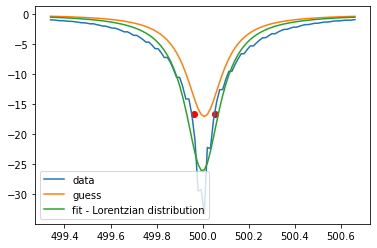

In [14]:
### Solution:

min_idx = int(700)
max_idx = int(800)

plt.scatter([f_min-FWHM/2.],[S_min/2.],color='r',marker='o')
plt.scatter([f_min+FWHM/2.],[S_min/2.],color='r',marker='o')

guess = [FWHM , f_min , -5]
gss_lorentzian = lorentzian(freqs, *guess)
popt, pcov = curve_fit(lorentzian, freqs[min_idx:max_idx], S21[min_idx:max_idx], maxfev = 100000, p0 = guess)
fit_lorentzian = lorentzian(freqs, *popt)
plt.plot(freqs[min_idx:max_idx], S21[min_idx:max_idx], label="data")
plt.plot(freqs[min_idx:max_idx], gss_lorentzian[min_idx:max_idx], label="guess")
plt.plot(freqs[min_idx:max_idx], fit_lorentzian[min_idx:max_idx], label="fit - Lorentzian distribution")
plt.legend()

print("FWHM from fit:", popt[0])

### 3. Fit the resonator to a Cauchy fit using the scipy `curve_fit` function. Do so by zooming in to the center of your data to get a good fit (right around the resonance)

Similarly to the Lorentzian function, you will need to make a guess at the FWHM, the resonance frequency, and an overall factor corresponding to the amplitude of your resonator dip (see the Lorentzian function above).

In [15]:
def cauchy_fit(x, G, x0, A):
    return A*cauchy.pdf(x, loc=x0, scale=G)

FWHM from fit: 0.09075902104855638


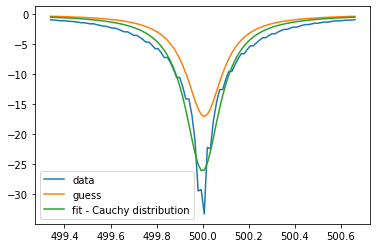

In [16]:
### Solution:

guess = [FWHM , f_min , -5]
popt, pcov = curve_fit(cauchy_fit, freqs[min_idx:max_idx], S21[min_idx:max_idx], maxfev = 100000, p0 = guess)
gss_cauchy = cauchy_fit(freqs, *guess)
fit_cauchy = cauchy_fit(freqs, *popt)
plt.plot(freqs[min_idx:max_idx], S21[min_idx:max_idx], label="data")
plt.plot(freqs[min_idx:max_idx], gss_cauchy[min_idx:max_idx], label="guess")
plt.plot(freqs[min_idx:max_idx], fit_cauchy[min_idx:max_idx], label="fit - Cauchy distribution")
plt.legend()

print("FWHM from fit:", popt[0])

### 4. Compare your Lorentzian fit to your Cauchy fit.

Compare those fits with the FWHM analytical calculation. How do they compare? 

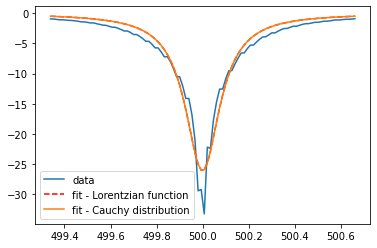

In [17]:
### Solution:

guess = [FWHM , f_min , -5]
popt, pcov = curve_fit(cauchy_fit, freqs[min_idx:max_idx], S21[min_idx:max_idx], maxfev = 100000, p0 = guess)
fit_cauchy = cauchy_fit(freqs, *popt)
plt.plot(freqs[min_idx:max_idx], S21[min_idx:max_idx], label="data")
plt.plot(freqs[min_idx:max_idx], fit_lorentzian[min_idx:max_idx], label="fit - Lorentzian function", ls='--', color="red")
plt.plot(freqs[min_idx:max_idx], fit_cauchy[min_idx:max_idx], label="fit - Cauchy distribution")
plt.legend()

### 5. What is the difference between a Lorentzian and a Cauchy fit? Which one should be used for fitting resonators?

(To do, find reference/write about it)

### 6. Use the linewidth you fitted to compute the quality factor of your resonator.

In [18]:
### Solution:

kappa = popt[0] ## Resonator linewidth (gamma of the Lorentzian function)
f = popt[1] ## Resonator center frequency
Q = f/kappa
print("Resonator quality factor is ~" + str(int(Q)))

Resonator quality factor is ~5509


### 7. Compare this quality factor to the quality factor of the readout resonator in the QICK paper: https://arxiv.org/abs/2110.00557 Figure 14

In [19]:
### Solution:

kappa = 1e6 ## Resonator linewidth from QICK paper
f = 8.5015e9 ## Resonator center frequency from QICK paper
Q = f/kappa
print("Resonator quality factor is ~" + str(int(Q)))

Resonator quality factor is ~8501


In [20]:
## Save data (optional)
import pickle
saveDict = {'freqs': freqs, 'S21': S21, 'xi_v': xi_v, 'xq_v': xq_v}

with open('resData_iq.pkl', 'wb') as handle:
    pickle.dump(saveDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

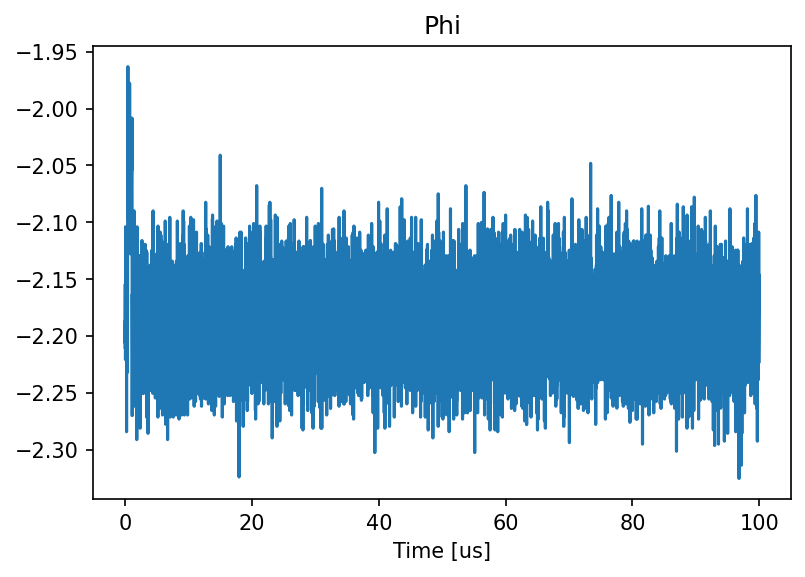

In [26]:
class PhaseFastProgram(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=1)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'],gen_ch=self.cfg['gen_ch'],ro_ch=self.cfg['ro_ch'])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(0.7*self.cfg['period'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['pulse_freq'],                             
                             gen_ch  = self.cfg['gen_ch'])
        
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'], phrst=0, mode="periodic")
        
        # Write conditional register.
        self.regwi(0,2,self.cfg['cond_jump'],"Conditional Jump")
        
        # Send pulse out.
        self.pulse(ch=self.cfg["gen_ch"])
        
        # Sync.
        self.synci(self.us2cycles(self.cfg['wait_start']))
    
    def body(self):
        # Apply conditional logic statement: When number is smaller than threshold, skip over playing the pulse.
        self.condj(0,2,'!=',15,'JUMP')
        self.trigger(pins=[4,5,6,7,8,9,10,11]) # play readout pulse
        self.label('JUMP')
        
        self.trigger(adcs=self.ro_chs, pins=[0])                
        self.synci(self.us2cycles(self.cfg['period']))
        
config={"gen_ch"      : 2,
        "ro_ch"       : 6,
        "reps"        : 10000,
        "pulse_length": 10,
        "pulse_gain"  : 30000, # [DAC units]
        "pulse_freq"  : 498, # [MHz]
        "cond_jump"   : 10,
        "period"      : 0.01,
        "wait_start"  : 20
       }

prog = PhaseFastProgram(soccfg, config)
prog.acquire(soc, progress=False)

# Plot data.
nsamp = prog.ro_chs[config['ro_ch']]['length'] # samples for each capture
di = prog.di_buf[0]/nsamp # Averaging
dq = prog.dq_buf[0]/nsamp # Averaging
diq = di + 1j*dq
a = np.abs(diq)
phi = np.angle(diq)
n = config['period']*np.arange(len(di)) # Sampling period

#Plot results.
# plt.figure(dpi=150)
# plt.plot(n,di)
# plt.title("Real Part")

# plt.figure(dpi=150)
# plt.plot(n,dq)
# plt.title("Imaginary Part")

plt.figure(dpi=150)
plt.plot(n,np.unwrap(phi))
plt.xlabel("Time [us]");
plt.title("Phi");